In [101]:
import numpy as np
import pandas as pd
import string
import pickle

import sklearn
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import sent_tokenize

import random

random_state = 0
np.random.seed(random_state)
random.seed(random_state)

In [102]:
sklearn.__version__

'0.20.1'

## Data Loading and Splits

In [103]:
filename = '../../data/final_annotated_data.csv'
df = pd.read_csv(filename)

print(df.is_answerable_orig.value_counts())
print('Total', len(df))

N    1754
Y    1094
S    1074
Name: is_answerable_orig, dtype: int64
Total 3922


In [104]:
# Column Renames
cols = ['question', 'review0', 'review1', 'review2', 'review3', 'review4', 'is_answerable', 'is_answerable_human', 'expert']
df = df.rename(columns={'is_answerable_orig': 'is_answerable', 'is_answerable_new': 'is_answerable_human'})[cols]

def filter_data(df):
    df = df[df.is_answerable.notnull()]
    df = df[df.review0.notnull()]
    return df

L = len(df)
df = filter_data(df)
assert L == len(df)

In [105]:
expert_df = df[df.expert]
test_df_all = expert_df[expert_df.is_answerable_human.notnull()]
print(len(df))
print(len(expert_df))
print(len(test_df_all))
print(len(test_df_all[test_df_all.is_answerable != 'N']))

3922
625
135
70


In [106]:
def print_stats(df, name='df'):
    print(name.upper())
    print('Length = %d' % len(df))
    print('Labels Counts')
    print(df.label.value_counts() / len(df))
    #print('IsAnswerableHuman Counts')
    #print(df.is_answerable_human.value_counts()  / len(df))
    print()
    
"""
test_df = df[df.expert]
train_df_part1 = df[~df.expert]

test_df_part1 = test_df[test_df.is_answerable_human.notnull()]
expert_rest_df = test_df[test_df.is_answerable_human.isnull()]

val_df, test_df_part2, train_df_part2 = np.split(expert_rest_df.sample(frac=1), [200, 270])

train_df = pd.concat([train_df_part1, train_df_part2]).sample(frac=1)
test_df = pd.concat([test_df_part1, test_df_part2]).sample(frac=1)
"""

df = df[df.is_answerable != 'N']

non_expert_df = df[~df.expert]
expert_df = df[df.expert]
test_df_all = expert_df[expert_df.is_answerable_human.notnull()]

train_df, val_df = np.split(non_expert_df.sample(frac=1, random_state=random_state), [int(0.9*len(non_expert_df))])



label_map = {'N': 0, 'S': 0, 'Y': 1}

def label_func(df):
    df['label'] = df.is_answerable.apply(lambda x: label_map[x])

label_func(train_df)
label_func(val_df)
label_func(test_df)


print_stats(train_df, 'train')
print_stats(val_df, 'val')
print_stats(test_df, 'test')


TRAIN
Length = 1710
Labels Counts
1    0.505263
0    0.494737
Name: label, dtype: float64

VAL
Length = 191
Labels Counts
0    0.549738
1    0.450262
Name: label, dtype: float64

TEST
Length = 70
Labels Counts
1    0.7
0    0.3
Name: label, dtype: float64



In [107]:
def get_reviews(row):
    all_reviews = ''
    for key in ['review0', 'review1', 'review2', 'review3', 'review4']:
        if not isinstance(row[key], float):
            all_reviews += row[key].strip(' ').strip('-')
            all_reviews += ' '
    return all_reviews.strip()


def add_reviews(df):
    df['reviews'] = df.apply(lambda x: get_reviews(x), axis = 1)
    return df


train_df, test_df, val_df = list(map(add_reviews, [train_df, test_df, val_df]))

## TF IDF Vectorizer

In [108]:
"""
df = pd.read_csv('../../data/train-qar_sample_100000.csv')
df = add_reviews(df)
print(len(df))

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer.fit(list(df.question.values) + list(df.reviews.values))

with open('../../data/tfidf_vectorizer.pkl', 'wb') as fp:
    pickle.dump(tfidf_vectorizer, fp)
"""

"\ndf = pd.read_csv('../../data/train-qar_sample_100000.csv')\ndf = add_reviews(df)\nprint(len(df))\n\ntfidf_vectorizer = TfidfVectorizer(stop_words='english')\ntfidf_vectorizer.fit(list(df.question.values) + list(df.reviews.values))\n\nwith open('../../data/tfidf_vectorizer.pkl', 'wb') as fp:\n    pickle.dump(tfidf_vectorizer, fp)\n"

In [109]:
with open('../../data/tfidf_vectorizer.pkl', 'rb') as fp:
    tfidf_vectorizer = pickle.load(fp)

In [110]:
len(tfidf_vectorizer.vocabulary_)

158752

## w2v Vectorizer

In [111]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 300

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [112]:
with open('../../data/w2v_vectorizer.pkl', 'rb') as fp:
    w2v_vectorizer = pickle.load(fp)

In [113]:
"""
import numpy as np

with open("../../data/glove.6B.300d.txt", "rb") as lines:
    w2v = {str(line.split()[0].decode('UTF-8')): np.array(list(map(float, line.split()[1:])))
           for line in lines}

w2v_vectorizer = MeanEmbeddingVectorizer(w2v)
with open('../../data/w2v_vectorizer.pkl', 'wb') as fp:
    pickle.dump(w2v_vectorizer, fp)
"""

'\nimport numpy as np\n\nwith open("../../data/glove.6B.300d.txt", "rb") as lines:\n    w2v = {str(line.split()[0].decode(\'UTF-8\')): np.array(list(map(float, line.split()[1:])))\n           for line in lines}\n\nw2v_vectorizer = MeanEmbeddingVectorizer(w2v)\nwith open(\'../../data/w2v_vectorizer.pkl\', \'wb\') as fp:\n    pickle.dump(w2v_vectorizer, fp)\n'

## Features

In [114]:
train_df_raw, test_df_raw, val_df_raw = list(map(lambda x: x.copy(), [train_df, test_df, val_df]))

In [115]:
def tokenize(text):
    punctuations = string.punctuation.replace("\'", '')

    for ch in punctuations:
        text = text.replace(ch, " " + ch + " ")

    tokens = text.split()
    for i, token in enumerate(tokens):
        if not token.isupper():
            tokens[i] = token.lower()
    return tokens

In [116]:
"""
x = vectorizer.transform(['It is a total idiot'])
y = vectorizer.transform(['It is not a total idiocy'])

print(type(x), '|\n', x.shape, '|\n', x, '|\n', len(x.toarray()[0]))
print("-"*50)
print(type(y), '|\n', y.shape, '|\n', y, '|\n', len(y.toarray()[0]))
print("-"*50)
print(x.toarray().dot(y.toarray().transpose())[0][0])
"""

'\nx = vectorizer.transform([\'It is a total idiot\'])\ny = vectorizer.transform([\'It is not a total idiocy\'])\n\nprint(type(x), \'|\n\', x.shape, \'|\n\', x, \'|\n\', len(x.toarray()[0]))\nprint("-"*50)\nprint(type(y), \'|\n\', y.shape, \'|\n\', y, \'|\n\', len(y.toarray()[0]))\nprint("-"*50)\nprint(x.toarray().dot(y.toarray().transpose())[0][0])\n'

In [117]:
def n_intersection(q, r):
    return len(set(q).intersection(set(r)))

def w2v_sim(q, r):
    # dot product of q and r as w2v vectors
    q_vec = w2v_vectorizer.transform([q])
    r_vec = w2v_vectorizer.transform([r])
    return q_vec.dot(r_vec.transpose())[0][0]

def tf_idf_sim(q, r):
    # dot product of q and r as tfidf vectors
    q_vec = tfidf_vectorizer.transform([q])
    r_vec = tfidf_vectorizer.transform([r])
    return q_vec.dot(r_vec.transpose()).toarray()[0][0]

def tf_idf_sim_sentence(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = tfidf_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return max([q_vec.dot(tfidf_vectorizer.transform([r]).transpose()).toarray()[0][0] for r in rs])

def w2v_sim_sentence(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = w2v_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return max([q_vec.dot(w2v_vectorizer.transform([r]).transpose())[0][0] for r in rs])

def tf_idf_sim_sentence_mean(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = tfidf_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return np.mean([q_vec.dot(tfidf_vectorizer.transform([r]).transpose()).toarray()[0][0] for r in rs])

def w2v_sim_sentence_mean(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = w2v_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return np.mean([q_vec.dot(w2v_vectorizer.transform([r]).transpose())[0][0] for r in rs])

def add_features(df):
    df['q_tokens']       = df.question.apply(lambda x: tokenize(x))
    df['r_tokens']       = df.reviews.apply(lambda x: tokenize(x))
    df['r_sents']        = df.reviews.apply(lambda x: sent_tokenize(x))
    df['n_q']            = df.q_tokens.apply(lambda x: len(x))
    df['n_r']            = df.r_tokens.apply(lambda x: len(x))
    df['n_intersection'] = df.apply(lambda x: len(set(x.q_tokens).intersection(set(x.r_tokens))), axis=1)
    df['intr_frac']      = df.n_intersection / df.n_q
    df['tfidf']          = df.apply(lambda x: tf_idf_sim(x.question, x.reviews), axis=1)
    df['w2v']            = df.apply(lambda x: w2v_sim(x.question, x.reviews), axis=1)
    df['w2v_sent']       = df.apply(lambda x: w2v_sim_sentence(x.question, x.r_sents), axis=1)
    df['tfidf_sent']     = df.apply(lambda x: tf_idf_sim_sentence(x.question, x.r_sents), axis=1)
    df['w2v_sent_mean']  = df.apply(lambda x: w2v_sim_sentence_mean(x.question, x.r_sents), axis=1)
    df['tfidf_sent_mean']= df.apply(lambda x: tf_idf_sim_sentence_mean(x.question, x.r_sents), axis=1)
    return df


In [118]:
train_df, test_df, val_df = list(map(add_features, [train_df_raw, test_df_raw, val_df_raw]))

In [119]:
for typ, df in [('sugg_train', train_df), ('sugg_test', test_df), ('sugg_val', val_df)]:
    pickle.dump(df, open('../../data/' + typ + '_df_features.pkl', 'wb'))

train_df_raw, test_df_raw, val_df_raw = None, None, None

## Feature Cols

In [120]:
X_cols = ['n_q', 'n_r', 'n_intersection', 'intr_frac']
Y_cols = 'label'

## Analysis

In [121]:
#train_df = pickle.load(open('../../data/' + 'sugg_train' + '_df_features.pkl', 'rb'))
#test_df = pickle.load(open('../../data/' + 'sugg_test' + '_df_features.pkl', 'rb'))
#val_df = pickle.load(open('../../data/' + 'sugg_val' + '_df_features.pkl', 'rb'))

In [122]:
df = train_df

q = df.question.iloc[1]
r = df.reviews.iloc[1]
q_tokens = df.q_tokens.iloc[1]
r_tokens = df.r_tokens.iloc[1]

# q, r, set(q_tokens).intersection(set(r_tokens))

In [123]:
df[[Y_cols] + X_cols].groupby(Y_cols).mean()

,n_q,n_r,n_intersection,intr_frac
label,,,,
0,18.144208,372.418440,9.594563,0.560721
1,16.888889,385.908565,9.584491,0.605137


## Training

In [124]:
train_df.head()

,question,review0,review1,review2,review3,review4,is_answerable,is_answerable_human,expert,label,...,n_q,n_r,n_intersection,intr_frac,tfidf,w2v,w2v_sent,tfidf_sent,w2v_sent_mean,tfidf_sent_mean
2282,"Can this hold high or low readings, such as vo...",It comes in a nice case with heavy duty webbin...,"As a born engineer, I always want a clamp mete...",all the others I looked at would read AC amp's...,Purchased this meter to use for solar and wind...,I'm old school with the AMPROBE clamp on meter...,S,NaN,False,0,...,26,432,14,0.538462,0.032762,17.740481,18.501235,0.217032,17.620731,0.009281
1182,Will this fit a 2006 Chevy Silverado?,"First of all, as with most of the products whi...",-,-,-,-,S,NaN,False,0,...,8,97,2,0.250000,0.000000,16.431084,16.888393,0.000000,16.351522,0.000000
1808,Will it work with American made hair dryers?,I recently used this adapter to charger my pho...,"Based on other glowing reviews, orderd these b...","This is not to be confused with a ""converter,""...",Purchased these for a planned trip in January ...,Bought a package of two. Mine were not cheaply...,Y,NaN,False,1,...,9,427,5,0.555556,0.137032,17.708091,18.611827,0.290476,17.621727,0.026854
168,What is the age group for which this is approp...,It's a lot of fun to put together and definite...,We bought this for our family as a gift and as...,"Highly addictive, causes sleep loss. Took 3 da...",I was thinking about getting a globe as a gift...,what's great about this puzzle are 3 things:1....,Y,NaN,False,1,...,11,417,7,0.636364,0.145835,17.263271,17.741740,0.320058,17.118700,0.041030
1193,Is this size (2 in) ok for shoulder length hai...,It is just way too large and would work much b...,"I got both the 1"" and 2"" Remington Wet 2 Strai...",I have color-treated and very thick mid length...,I purchased this to replace my old Wet 2 Strai...,Too large of sections failed to dry quickly.Al...,Y,NaN,False,1,...,22,466,19,0.863636,0.503574,17.848459,18.441683,0.404836,17.822413,0.167604


In [125]:
extra_features = ['w2v', 'tfidf']
X_cols_all = X_cols + ['w2v_sent', 'w2v_sent_mean', 'tfidf_sent', 'tfidf_sent_mean']# + extra_features

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import svm 
from sklearn.ensemble import GradientBoostingClassifier


C = 1.0
models = []
models.extend([
    svm.LinearSVC(penalty='l2'), 
    svm.SVC(kernel='linear', C=C), 
    svm.SVC(C=10), 
    svm.SVC(C=100), 
    svm.LinearSVC(C=C), 
    svm.SVC(kernel='rbf', gamma=0.7, C=C)
    #svm.SVC(kernel='poly', degree=3, C=C)
    ])
numSVMs = len(models)
print(numSVMs)
models.append(LogisticRegression(C=100))
models.append(LogisticRegression(C=10))
models.append(LogisticRegression(C=1))
models.append(LogisticRegression(C=0.1))
models.append(LogisticRegression(C=0.01))
models.append(LogisticRegression(penalty='l1'))
models.append(DecisionTreeClassifier(max_depth=4))
models.append(RandomForestClassifier(n_estimators=3, max_depth=4))
models.append(RandomForestClassifier(n_estimators=10, max_depth=2))
models.append(RandomForestClassifier(n_estimators=10, max_depth=4))
models.append(GradientBoostingClassifier(n_estimators=10, max_depth=2))

for i in range(len(models)):
    print(models[i])
    #scaler = StandardScaler()
    #data = scaler.fit_transform(train_df[X_cols_all].values)
    models[i].fit(train_df[X_cols_all].values, train_df[Y_cols].values)
    

6
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.7, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=1, class_weight

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/V

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_sa

0 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
0.33 0.00
0.00 0.00


1 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.57 0.61
0.51 0.65


2 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.98 0.98
0.47 0.51


3 SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.00 1.00
0.45 0.65


6 LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.51 0.93
0.47 0.91
NO TH IS GOOD


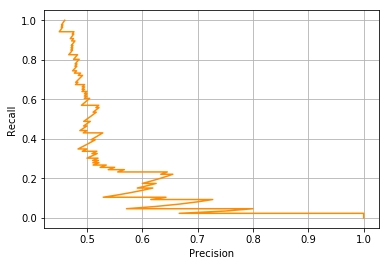



7 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.51 0.93
0.47 0.91
NO TH IS GOOD


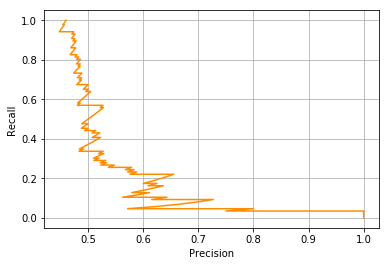



8 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.51 0.94
0.46 0.92
NO TH IS GOOD


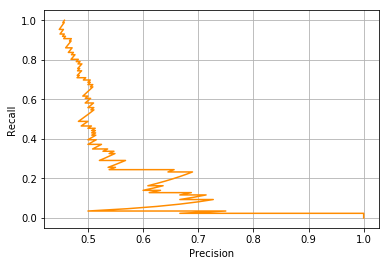



9 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.50 0.96
0.45 0.97
NO TH IS GOOD


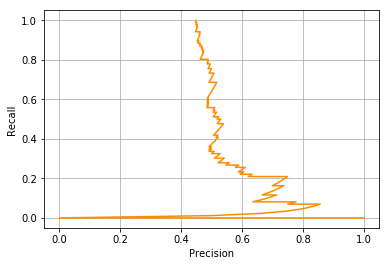



10 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.50 0.97
0.45 0.99
NO TH IS GOOD


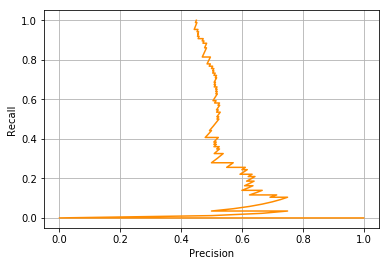



11 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.51 0.94
0.46 0.92
NO TH IS GOOD


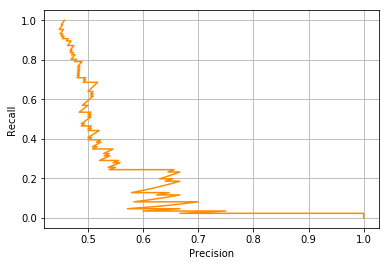



12 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.55 0.90
0.47 0.87
NO TH IS GOOD


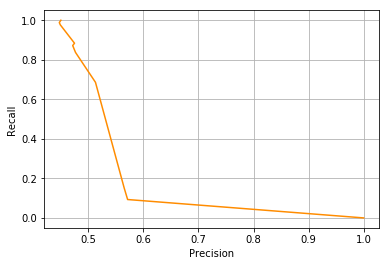



13 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.52 0.98
0.45 0.94
NO TH IS GOOD


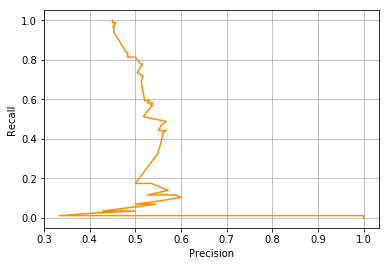



14 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.51 1.00
0.45 1.00
NO TH IS GOOD


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


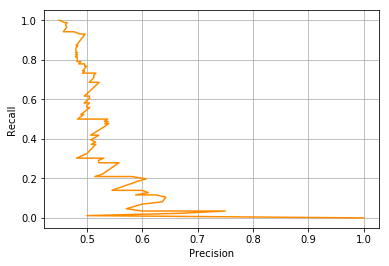



15 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.55 0.95
0.48 0.91
NO TH IS GOOD


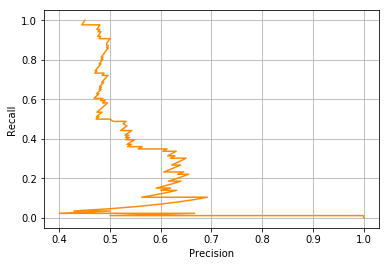



16 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
0.51 1.00
0.45 0.99
NO TH IS GOOD


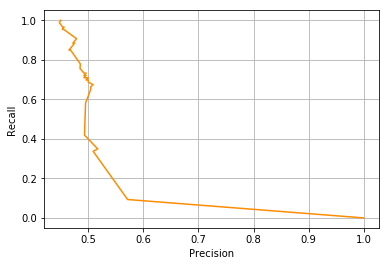

In [134]:
from sklearn.metrics import classification_report

def predictions_k(model, probs, th):
    return probs[:, 1] >= th

th = 0.4#0.308180111378#0.576310286793

#numSVMs = 0

#small_models = [models[6], models[12]]
for i, model in enumerate(models):
    print(i, model)
    for j, df in enumerate([train_df, val_df]):
        X = df[X_cols_all].values
        Y = df[Y_cols].values
        
        if i >= numSVMs:
            probs = model.predict_proba(X)
            predictions = predictions_k(model, probs, th)
            report = classification_report(Y, predictions, output_dict = True)
            print('%.2f %.2f' %( report['1']['precision'], report['1']['recall']))
            if j == 1 or j == 2:
                plot_curves(model, probs, Y)
        else:
            predictions = model.predict(X)
            report = classification_report(Y, predictions, output_dict = True)
            print('%.2f %.2f' %( report['1']['precision'], report['1']['recall']))
            
        #print(pd.Series(predictions).value_counts())
        
        #print("-"*50)
    
    #print("-"*100)
    print('\n')

In [131]:
from sklearn.metrics import auc, roc_curve
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_curves(model, probs, ytrue):

    """
    fpr, tpr, thresholds = roc_curve(ytrue, probs, pos_label=1)
    score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % score)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    """
    #print(ytrue.shape, probs.shape)
    precision, recall, thresholds = precision_recall_curve(ytrue, probs[:, 1])
    th = None
    pr = None
    re = None
    for i in range(len(thresholds)):
        p = precision[i]
        r = recall[i]
        t = thresholds[i]
        if p >= 0.65 and r >= 0.65:
            th = t
            pr = p
            re = r
    if th != None:
        print("THRESHOLD:", th, "at precision ", pr, ' and recall ', re)
    else:
        print("NO TH IS GOOD")
    
    plt.figure()
    plt.plot(precision, recall, color='darkorange')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.grid()
    plt.show()

    """
    thresholds = [0.25, 0.5, 0.75]
    for th in thresholds:
        #print(probs)
        predictions = [1 if prob > th else 0 for prob in probs]
        #predictions = model.predict(val_df[X_cols].values)
        print(pd.Series(predictions).value_counts())
        print(classification_report(ytrue, predictions))
    """
    
    


## Human Performance

In [ ]:
predictions = test_df_human.is_answerable_human.apply(lambda x: label_map[x]).values
labels = test_df_human.is_answerable.apply(lambda x: label_map[x]).values
print(classification_report(labels, predictions))

## Saving

In [136]:
with open('../../data/model_answerability.pkl', 'wb') as fp:
    pickle.dump(models[6], fp)

In [ ]:
with open('../../data/model_answerability.pkl', 'rb') as fp:
    model = pickle.load(fp)

# visualization

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets


for xcols in [X_cols_all, X_cols + ['w2v_sent', 'w2v_sent_mean', 'tfidf_sent', 'tfidf_sent_mean'], ['w2v_sent', 'tfidf_sent', 'w2v_sent_mean', 'tfidf_sent_mean']]:
    new_df = train_df[xcols]
    corr_matrix = new_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    xcols = list(set(xcols) - set(to_drop))
    print(xcols)
    
    for df in [train_df, val_df, test_df]:
        X = df[xcols].values
        color = df[Y_cols].values

        # Next line to silence pyflakes. This import is needed.
        Axes3D

        n_points = len(X)
        #X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
        n_neighbors = 5
        n_components = 2

        fig = plt.figure(figsize=(15, 8))
        plt.suptitle("Manifold Learning with %i points, %i neighbors"
                     % (n_points, n_neighbors), fontsize=14)


        ax = fig.add_subplot(251, projection='3d')
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
        ax.view_init(4, -72)

        methods = ['standard', 'ltsa', 'modified']
        labels = ['LLE', 'LTSA', 'Modified LLE']

        for i, method in enumerate(methods):
            print("METHOD::::::" + method)
            t0 = time()
            Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                                eigen_solver='auto',
                                                method=method).fit_transform(X)
            t1 = time()
            print("%s: %.2g sec" % (methods[i], t1 - t0))

            ax = fig.add_subplot(252 + i)
            plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
            plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
            ax.xaxis.set_major_formatter(NullFormatter())
            ax.yaxis.set_major_formatter(NullFormatter())
            plt.axis('tight')

        t0 = time()
        Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
        t1 = time()
        print("Isomap: %.2g sec" % (t1 - t0))
        ax = fig.add_subplot(257)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.title("Isomap (%.2g sec)" % (t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')


        t0 = time()
        mds = manifold.MDS(n_components, max_iter=100, n_init=1)
        Y = mds.fit_transform(X)
        t1 = time()
        print("MDS: %.2g sec" % (t1 - t0))
        ax = fig.add_subplot(258)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.title("MDS (%.2g sec)" % (t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')


        t0 = time()
        se = manifold.SpectralEmbedding(n_components=n_components,
                                        n_neighbors=n_neighbors)
        Y = se.fit_transform(X)
        t1 = time()
        print("SpectralEmbedding: %.2g sec" % (t1 - t0))
        ax = fig.add_subplot(259)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        t0 = time()
        tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
        Y = tsne.fit_transform(X)
        t1 = time()
        print("t-SNE: %.2g sec" % (t1 - t0))
        ax = fig.add_subplot(2, 5, 10)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.title("t-SNE (%.2g sec)" % (t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        print("REACHED END")
        plt.show()

In [ ]:
plt.show()

In [ ]:
Y_cols

In [ ]:
train_df[xcols]